In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

In [ ]:
pip install scikeras

In [ ]:
# Pre-Loading
y_train = pd.read_csv("FE results/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE results/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])


# Load Data
X_train = pd.read_csv("FE results/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])


In [ ]:
def Model_training(model, X_train, y_train, X_test, y_test, pred_list):
    result = {}
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    pred_list.append(np.concatenate((train_pred, test_pred), axis=0))
    result['Train MAE'] = mean_absolute_error(y_train, train_pred)
    result['Train RMSE'] = np.sqrt(mean_squared_error(y_train, train_pred))
    result['Test MAE'] = mean_absolute_error(y_test, test_pred)
    result['Test RMSE'] = np.sqrt(mean_squared_error(y_test, test_pred))

    if isinstance(model, GridSearchCV):
        result['Best Params'] = model.best_params_

    return result

def Multiple_models(X_train, y_train, X_test, y_test, cv, verbose):
    Results = pd.DataFrame(columns=['Train MAE', 'Train RMSE', 'Test MAE', 'Test RMSE'])
    pred_list = []

    print('\n\n# Linear Regression')
    pipeline_lr = Pipeline([
        ('regressor', LinearRegression())
    ])
    params_lr = {'regressor__fit_intercept': [True, False]}
    model_lr = GridSearchCV(pipeline_lr, params_lr, cv=cv, verbose=verbose)
    result_lr = Model_training(model_lr, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_lr, ignore_index=True)

    print('\n\n# Lasso')
    pipeline_lasso = Pipeline([('regressor', Lasso())])
    params_lasso = {'regressor__alpha': [0.5, 1], 'regressor__max_iter': [1000]}
    model_lasso = GridSearchCV(pipeline_lasso, params_lasso, cv=cv, verbose=verbose)
    result_lasso = Model_training(model_lasso, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_lasso, ignore_index=True)

    print('\n\n# Random Forest')
    regressor_rf = RandomForestRegressor()
    params_rf = {
        'max_depth': [8, 16, 24],
        'n_estimators': [100, 200],
        'criterion': ['squared_error'],
        'min_samples_split': [2, 4],
        'max_features': ['sqrt']
    }
    model_rf = GridSearchCV(regressor_rf, params_rf, cv=cv, verbose=verbose)
    result_rf = Model_training(model_rf,  X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_rf, ignore_index=True)


    Results.index = [model_name[i] for i in range(3)]
    return Results, pred_list

In [ ]:
model_name = {0: 'Linear Regression', 1:'Lasso',2: 'Random Forest'}
cv_n_splits = 5
cv = TimeSeriesSplit(n_splits=cv_n_splits)
verbose = 2
based_days = 7
next_days = 1
pred_total = {}

results_total = []

# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)

print(f'Results {Results}')
print(f'pred_list {pred_list}')
results_total.append(Results)

print('\n\n##################################################\nWithout Feature Engineering')
print(Results)
pred_total['Without Feature Engineering'] = pred_list

# Boruta
print('\n####### Boruta #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_boruta.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_boruta.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nBoruta')
print(Results)
pred_total['Boruta'] = pred_list

# PCA
print('\n####### PCA #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_pca.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_pca.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nPCA')
print(Results)
pred_total['PCA'] = pred_list

# t-SNE
print('\n####### t-SNE #######')
# Load Data
X_train = pd.read_csv('./FE results/Train_tsne.csv')
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_tsne.csv")
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
# Models Training
Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
results_total.append(Results)

print('\n\n##################################################\nt-SNE')
print(Results)
pred_total['tSNE'] = pred_list

# Save Results
results_ = pd.concat(results_total, keys=['Without FE', 'Boruta', 'PCA', 't-SNE'])

results_.to_csv(f'results_1.csv')



# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s


# Lasso
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .....regressor__alpha=0.5, re

<ipython-input-10-56916a9181e9>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)


[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.0s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.0s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s


<ipython-input-10-56916a9181e9>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)




# Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   1.0s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-10-56916a9181e9>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
<ipython-input-10-56916a9181e9>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)


Results                    Train MAE  Train RMSE  Test MAE  Test RMSE  \
Linear Regression   1.483713    2.185955  2.103814   2.657183   
Lasso               1.483569    2.214203  1.680404   2.190981   
Random Forest       0.560805    0.842992  9.493747  11.861969   

                                                         Best Params  
Linear Regression                {'regressor__fit_intercept': False}  
Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
Random Forest      {'criterion': 'squared_error', 'max_depth': 24...  
pred_list [array([[ 42.66996931],
       [ 42.97928086],
       [ 43.08370309],
       ...,
       [193.49644393],
       [193.27322842],
       [192.91755568]]), array([ 43.01570071,  43.12845812,  43.30113045, ..., 194.89709684,
       194.3899658 , 194.11892398]), array([ 43.11923692,  43.28477489,  43.67181248, ..., 173.50959914,
       173.11134923, 172.93309917])]


##################################################
Without Feature Engin

<ipython-input-10-56916a9181e9>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.6s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   1.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-10-56916a9181e9>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
<ipython-input-10-56916a9181e9>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)




##################################################
Boruta
                   Train MAE  Train RMSE  Test MAE  Test RMSE  \
Linear Regression   1.480203    2.206923  1.811878   2.345353   
Lasso               1.484431    2.221659  1.678116   2.190818   
Random Forest       0.563283    0.840641  9.118753  11.600152   

                                                         Best Params  
Linear Regression                {'regressor__fit_intercept': False}  
Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
Random Forest      {'criterion': 'squared_error', 'max_depth': 16...  

####### PCA #######


# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_int

<ipython-input-10-56916a9181e9>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.7s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
<ipython-input-10-56916a9181e9>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
<ipython-input-10-56916a9181e9>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)
<ipython-input-10-56916a9181e9>:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/usr/local/lib/python3.10/dist-packag



##################################################
PCA
                   Train MAE  Train RMSE   Test MAE  Test RMSE  \
Linear Regression   1.925108    2.693755  75.588110  80.690876   
Lasso               2.077837    2.850734  75.588110  80.643630   
Random Forest       1.159729    1.660729  68.999369  72.720467   

                                                         Best Params  
Linear Regression                 {'regressor__fit_intercept': True}  
Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
Random Forest      {'criterion': 'squared_error', 'max_depth': 16...  

####### t-SNE #######


# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)




##################################################
t-SNE
                   Train MAE  Train RMSE   Test MAE  Test RMSE  \
Linear Regression  12.969487   15.906425  72.819892  77.302222   
Lasso              12.968160   15.907869  72.814629  77.303395   
Random Forest       3.154653    4.138131  74.918610  83.073334   

                                                         Best Params  
Linear Regression                 {'regressor__fit_intercept': True}  
Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
Random Forest      {'criterion': 'squared_error', 'max_depth': 8,...  


<ipython-input-10-56916a9181e9>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)


In [ ]:
results_

Train MAE  Train RMSE   Test MAE  Test RMSE  \
Without FE Linear Regression   1.483713    2.185955   2.103814   2.657183   
           Lasso               1.483569    2.214203   1.680404   2.190981   
           Random Forest       0.560805    0.842992   9.493747  11.861969   
Boruta     Linear Regression   1.480203    2.206923   1.811878   2.345353   
           Lasso               1.484431    2.221659   1.678116   2.190818   
           Random Forest       0.563283    0.840641   9.118753  11.600152   
PCA        Linear Regression   1.925108    2.693755  75.588110  80.690876   
           Lasso               2.077837    2.850734  75.588110  80.643630   
           Random Forest       1.159729    1.660729  68.999369  72.720467   
t-SNE      Linear Regression  12.969487   15.906425  72.819892  77.302222   
           Lasso              12.968160   15.907869  72.814629  77.303395   
           Random Forest       3.154653    4.138131  74.918610  83.073334   

                                                                    Best Params  
Without FE Linear Regression                {'regressor__fit_intercept': False}  
           Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 24...  
Boruta     Linear Regression                {'regressor__fit_intercept': False}  
           Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 16...  
PCA        Linear Regression                 {'regressor__fit_intercept': True}  
           Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 16...  
t-SNE      Linear Regression                 {'regressor__fit_intercept': True}  
           Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 8,...

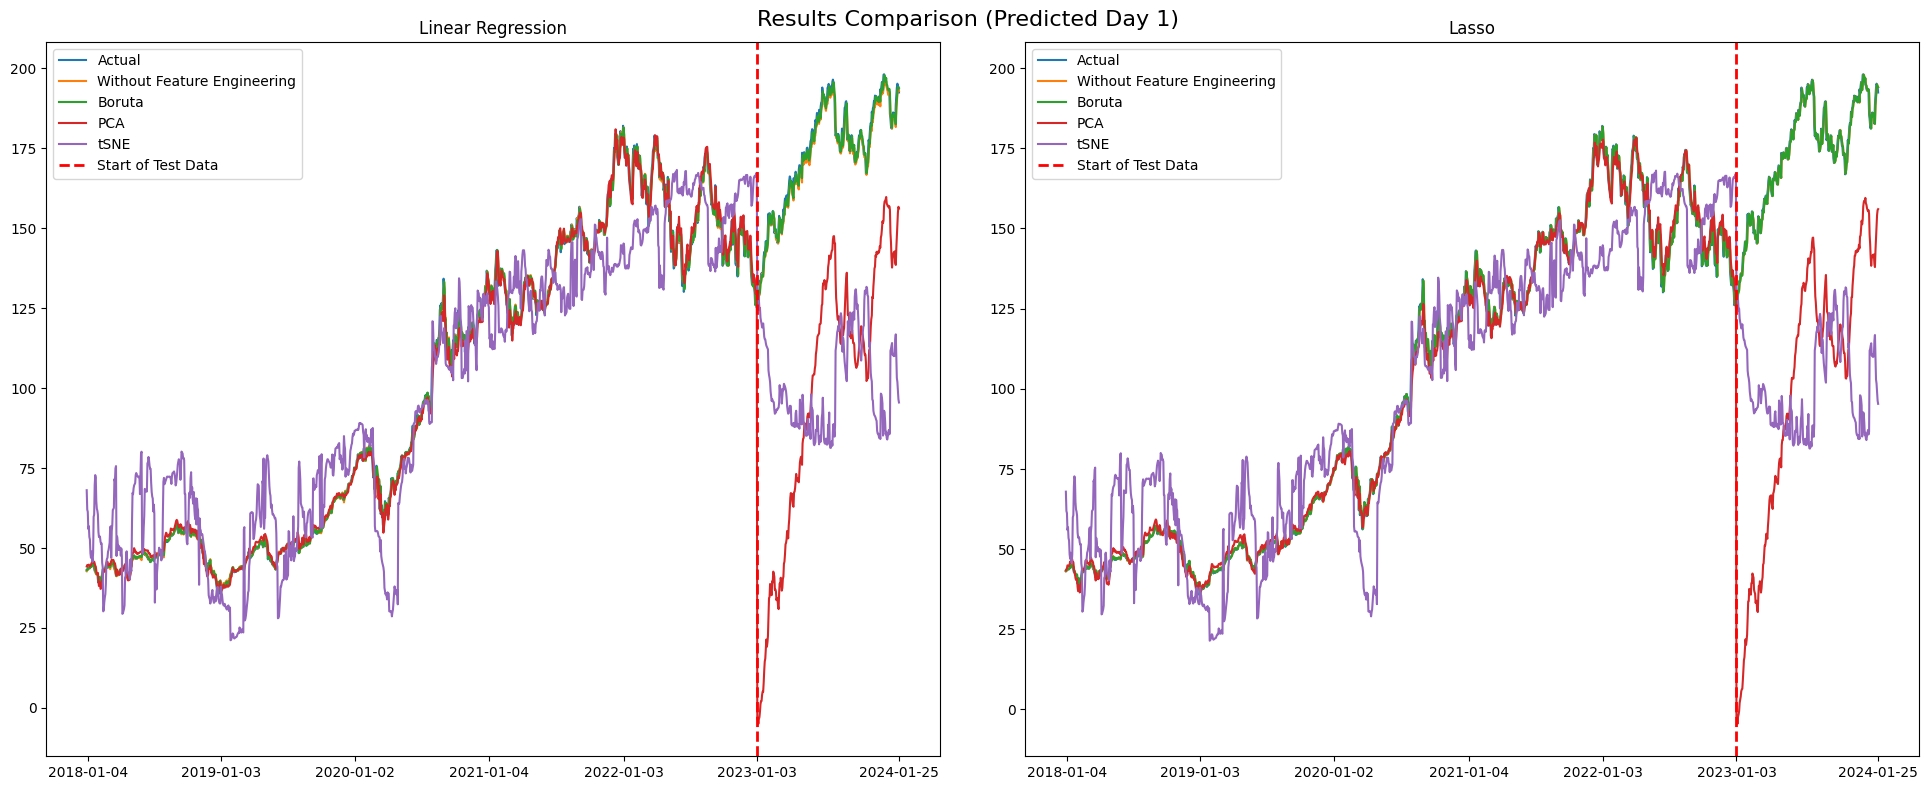

In [ ]:
plt.rcParams["figure.figsize"] = (20, 16) # Width, height in inches
date = np.concatenate((Train_date, Test_date), axis=0)
axis_x = np.array(['2018-01-04', '2019-01-03', '2020-01-02', '2021-01-04', '2022-01-03', '2023-01-03','2024-01-25'])
y_actual = np.concatenate((y_train, y_test), axis=0)
# For each subplot, you can now set individual titles and labels without them overlapping.
for key, value in model_name.items():
    ax = plt.subplot(2, 2, key + 1)
    model = key
    ax.set_title(value)
    plt.plot(y_actual, label='Actual')
    for key, value in pred_total.items():
        plt.plot(date, value[model], label=key)

    # Ensure the x parameter matches the format and actual point where the test data starts
    plt.axvline(x=np.where(date == '2023-01-03')[0][0], linewidth=2, color='r', linestyle='--', label='Start of Test Data')

    # Rotate xticks if they are overlapping

    # Set xticks to be more sparse to prevent overlap
    #plt.xticks(ticks=np.arange(0, len(date), step=int(len(date)/len(axis_x))), labels=axis_x)
    plt.xticks(axis_x)
    plt.legend()

# Adjust layout spacing to prevent labels and titles from overlapping
plt.tight_layout(pad=3.0)

# You can add a super title for the entire figure if you want
plt.suptitle('Results Comparison (Predicted Day 1)', fontsize=16)

# Show the plot
plt.show()

# Fine - tune

In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Pre-Loading
y_train = pd.read_csv("FE results/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE results/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])


# Load Data
X_train = pd.read_csv("FE results/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])

# Initialize scaler
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Normalize features
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Assuming y_train and y_test are single columns and not DataFrames at this point
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(input_data, target_data, n_steps):
    X, y = [], []
    for i in range(len(input_data) - n_steps):
        X.append(input_data[i:i+n_steps])
        y.append(target_data[i+n_steps, 0])  # Assuming target_data is the column vector
    return np.array(X), np.array(y)

n_steps = 7  # Define the number of steps in your sequence
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)



In [ ]:
def create_lstm_model(input_shape, optimizer='adam', lstm_units=50, dropout_rate=0.2, l2_regularization=0.01):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_regularizer=l2(l2_regularization)))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Assuming create_lstm_model and create_sequences are already defined

def run_optuna_optimization(X_train, y_train, X_test, y_test, n_steps, n_trials=5):
    def lstm_objective(trial):
        # Initialize scalers
        scaler_x = MinMaxScaler(feature_range=(0, 1))
        scaler_y = MinMaxScaler(feature_range=(0, 1))

        # Normalize features and targets
        X_train_scaled = scaler_x.fit_transform(X_train)
        X_test_scaled = scaler_x.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

        # Create sequences
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
        X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)


        batch_size = trial.suggest_categorical('batch_size', [32, 64])

        # Hyperparameters

        lstm_units = trial.suggest_categorical('lstm_units', [50, 100])
        dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)

        # Model definition
        model = create_lstm_model(input_shape=(n_steps, X_train_seq.shape[2]),
                                  lstm_units=lstm_units,
                                  dropout_rate=dropout_rate,
                                  optimizer=Adam(learning_rate=learning_rate))

        # Train the model
        model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=0)

        # Evaluate
        train_pred_scaled = model.predict(X_train_seq)
        test_pred_scaled = model.predict(X_test_seq)
        train_pred = scaler_y.inverse_transform(train_pred_scaled)
        test_pred = scaler_y.inverse_transform(test_pred_scaled)

        # Metrics
        train_mae = mean_absolute_error(y_train[n_steps:], train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train[n_steps:], train_pred))
        test_mae = mean_absolute_error(y_test[n_steps:], test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test[n_steps:], test_pred))

        trial.set_user_attr('train_mae', train_mae)
        trial.set_user_attr('train_rmse', train_rmse)
        trial.set_user_attr('test_mae', test_mae)
        trial.set_user_attr('test_rmse', test_rmse)

        return test_rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(lstm_objective, n_trials=n_trials)

    best_trial = study.best_trial

    # Re-train the best model to get predictions for visualization
    best_params = best_trial.params
    model = create_lstm_model(
        input_shape=(n_steps, X_train_seq.shape[2]),
        lstm_units=best_params['lstm_units'],
        dropout_rate=best_params['dropout_rate'],
        optimizer=Adam(learning_rate=best_params['learning_rate'])
     )
    model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, validation_split=0.2, verbose=0)

    # Predict with the best model
    train_pred = scaler_y.inverse_transform(model.predict(X_train_seq))
    test_pred = scaler_y.inverse_transform(model.predict(X_test_seq))
    pred_list = {'train_pred': train_pred, 'test_pred': test_pred}

    results = {
        'Feature Engineering Method': 'Method Name',  # This will be replaced by the actual method name later
        'Best Trial Train MAE': best_trial.user_attrs['train_mae'],
        'Best Trial Train RMSE': best_trial.user_attrs['train_rmse'],
        'Best Trial Test MAE': best_trial.user_attrs['test_mae'],
        'Best Trial Test RMSE': best_trial.user_attrs['test_rmse'],
        'Best Params': best_trial.params
    }

    return results, pred_list


In [ ]:

results_total = []
predictions_total = {}
# Placeholder for method names and corresponding data files
fe_methods_data = {
    'Without FE': ('./FE results/Train_original.csv', './FE results/Test_original.csv'),
    'Boruta': ('./FE results/Train_boruta.csv', './FE results/Test_boruta.csv'),
    'PCA': ('./FE results/Train_pca.csv', './FE results/Test_pca.csv'),
    't-SNE': ('./FE results/Train_tsne.csv', './FE results/Test_tsne.csv'),
}


for method_name, (train_file, test_file) in fe_methods_data.items():
    print(f'\n####### {method_name} #######')
    X_train = pd.read_csv(train_file).drop(columns=['Unnamed: 0', 'Date'])
    y_train = pd.read_csv("FE results/y_train.csv").drop(columns=['Unnamed: 0']).values.ravel()
    X_test = pd.read_csv(test_file).drop(columns=['Unnamed: 0', 'Date'])
    y_test = pd.read_csv("FE results/y_test.csv").drop(columns=['Unnamed: 0']).values.ravel()

    results, pred_list = run_optuna_optimization(X_train, y_train, X_test, y_test, n_steps, n_trials=10)
    results['Feature Engineering Method'] = method_name  # Set the method name in the results

    results_total.append(results)
    predictions_total[method_name] = pred_list  # Store predictions by method

# Convert results_total to DataFrame for easier analysis if needed
results_df = pd.DataFrame(results_total)
print(results_df)

# Now, predictions_total contains the pred_list for each feature engineering method


[I 2024-03-12 15:36:20,737] A new study created in memory with name: no-name-fc24481d-4b71-4738-8174-d0284c63bfc3



####### Without FE #######


<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-12 15:37:43,081] Trial 0 finished with value: 5.697301573370796 and parameters: {'lstm_units': 100, 'dropout_rate': 0.10280643752144909, 'learning_rate': 0.009549335594739887}. Best is trial 0 with value: 5.697301573370796.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 15:38:33,601] Trial 1 finished with value: 7.34016589883215 and parameters: {'lstm_units': 50, 'dropout_rate': 0.13237349416247263, 'learning_rate': 0.007056449173796345}. Best is trial 0 with value: 5.697301573370796.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 15:39:16,999] Trial 2 finished with value: 8.474394080543577 and parameters: {'lstm_units': 50, 'dropout_rate': 0.12485568821665068, 'learning_rate': 0.004219927171228372}. Best is trial 0 with value: 5.697301573370796.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-12 15:40:39,814] Trial 3 finished with value: 6.2434795024307945 and parameters: {'lstm_units': 100, 'dropout_rate': 0.10673129596360588, 'learning_rate': 0.0032059972265463155}. Best is trial 0 with value: 5.697301573370796.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-12 15:42:10,349] Trial 4 finished with value: 8.4803173987108 and parameters: {'lstm_units': 100, 'dropout_rate': 0.11279475394421357, 'learning_rate': 0.0011248232050150749}. Best is trial 0 with value: 5.697301573370796.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 14ms/step


[I 2024-03-12 15:43:42,438] Trial 5 finished with value: 8.544176886016665 and parameters: {'lstm_units': 100, 'dropout_rate': 0.17875238495591964, 'learning_rate': 0.0072549583074611864}. Best is trial 0 with value: 5.697301573370796.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 15:44:24,898] Trial 6 finished with value: 9.106646440123153 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1514308892141917, 'learning_rate': 0.0010103759465708185}. Best is trial 0 with value: 5.697301573370796.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-12 15:45:56,770] Trial 7 finished with value: 9.84406021345257 and parameters: {'lstm_units': 100, 'dropout_rate': 0.16679381508694896, 'learning_rate': 0.0018766783320042833}. Best is trial 0 with value: 5.697301573370796.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 11ms/step


[I 2024-03-12 15:47:27,247] Trial 8 finished with value: 10.791831259089086 and parameters: {'lstm_units': 100, 'dropout_rate': 0.10487621030154831, 'learning_rate': 0.003356689802271145}. Best is trial 0 with value: 5.697301573370796.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-12 15:48:50,510] Trial 9 finished with value: 9.267517231523595 and parameters: {'lstm_units': 100, 'dropout_rate': 0.13469862380700784, 'learning_rate': 0.0061413777190997615}. Best is trial 0 with value: 5.697301573370796.


9/9 [==============================] - 0s 8ms/step


[I 2024-03-12 15:50:22,850] A new study created in memory with name: no-name-f5ff1978-0a5b-475c-a16e-dfb1c818173b



####### Boruta #######


<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-12 15:51:53,493] Trial 0 finished with value: 8.38067096607347 and parameters: {'lstm_units': 100, 'dropout_rate': 0.17248389621664872, 'learning_rate': 0.0019931341322732814}. Best is trial 0 with value: 8.38067096607347.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-12 15:52:35,446] Trial 1 finished with value: 11.84131948986091 and parameters: {'lstm_units': 50, 'dropout_rate': 0.11252519998277162, 'learning_rate': 0.007948472258376228}. Best is trial 0 with value: 8.38067096607347.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-12 15:53:20,204] Trial 2 finished with value: 6.651767319113441 and parameters: {'lstm_units': 50, 'dropout_rate': 0.16940230854078608, 'learning_rate': 0.005529005149025118}. Best is trial 2 with value: 6.651767319113441.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 15:54:03,288] Trial 3 finished with value: 7.594888053281239 and parameters: {'lstm_units': 50, 'dropout_rate': 0.12628194185539968, 'learning_rate': 0.009913500301347307}. Best is trial 2 with value: 6.651767319113441.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 15:54:44,573] Trial 4 finished with value: 5.952642210353962 and parameters: {'lstm_units': 50, 'dropout_rate': 0.14808096308772914, 'learning_rate': 0.002310767210184682}. Best is trial 4 with value: 5.952642210353962.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-12 15:55:30,256] Trial 5 finished with value: 9.843771543524227 and parameters: {'lstm_units': 50, 'dropout_rate': 0.15432679127540563, 'learning_rate': 0.003205668287192824}. Best is trial 4 with value: 5.952642210353962.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-12 15:57:00,509] Trial 6 finished with value: 13.015573011283758 and parameters: {'lstm_units': 100, 'dropout_rate': 0.11839139818610049, 'learning_rate': 0.001980385533485418}. Best is trial 4 with value: 5.952642210353962.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-12 15:58:18,364] Trial 7 finished with value: 8.472070778726163 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1461528881916763, 'learning_rate': 0.00390003464427273}. Best is trial 4 with value: 5.952642210353962.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 15:59:06,713] Trial 8 finished with value: 10.794966939595119 and parameters: {'lstm_units': 50, 'dropout_rate': 0.10249770321649163, 'learning_rate': 0.0021843857454434297}. Best is trial 4 with value: 5.952642210353962.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 7ms/step


[I 2024-03-12 15:59:53,139] Trial 9 finished with value: 10.0938768599349 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1662725314763349, 'learning_rate': 0.0023935329358746025}. Best is trial 4 with value: 5.952642210353962.


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 16:00:35,334] A new study created in memory with name: no-name-857b7b0d-12aa-43d6-aa00-9d3ae027cb85



####### PCA #######


<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-12 16:02:04,863] Trial 0 finished with value: 80.07239669191722 and parameters: {'lstm_units': 100, 'dropout_rate': 0.12259423433288291, 'learning_rate': 0.0011654654205650987}. Best is trial 0 with value: 80.07239669191722.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 16:02:44,583] Trial 1 finished with value: 76.82975018042765 and parameters: {'lstm_units': 50, 'dropout_rate': 0.10920799008625354, 'learning_rate': 0.003658730136413961}. Best is trial 1 with value: 76.82975018042765.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 4ms/step


[I 2024-03-12 16:03:24,255] Trial 2 finished with value: 79.43031972040566 and parameters: {'lstm_units': 50, 'dropout_rate': 0.158284222604115, 'learning_rate': 0.0016187260004528574}. Best is trial 1 with value: 76.82975018042765.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 16:04:09,255] Trial 3 finished with value: 75.77746198811215 and parameters: {'lstm_units': 50, 'dropout_rate': 0.1453844340101539, 'learning_rate': 0.0033292763552708127}. Best is trial 3 with value: 75.77746198811215.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 16:04:57,638] Trial 4 finished with value: 76.7787732547554 and parameters: {'lstm_units': 50, 'dropout_rate': 0.18385172078968215, 'learning_rate': 0.003730520452951115}. Best is trial 3 with value: 75.77746198811215.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-12 16:06:27,250] Trial 5 finished with value: 79.22680160186592 and parameters: {'lstm_units': 100, 'dropout_rate': 0.19881422486617384, 'learning_rate': 0.0015172110972069964}. Best is trial 3 with value: 75.77746198811215.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 16:07:07,432] Trial 6 finished with value: 81.39032556483347 and parameters: {'lstm_units': 50, 'dropout_rate': 0.17293420732967713, 'learning_rate': 0.003272140369023205}. Best is trial 3 with value: 75.77746198811215.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-12 16:07:48,692] Trial 7 finished with value: 78.1533994882386 and parameters: {'lstm_units': 50, 'dropout_rate': 0.17814371327249798, 'learning_rate': 0.0014143409945202904}. Best is trial 3 with value: 75.77746198811215.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 16:08:39,868] Trial 8 finished with value: 78.32645616653247 and parameters: {'lstm_units': 50, 'dropout_rate': 0.14621139272373246, 'learning_rate': 0.004130205106535296}. Best is trial 3 with value: 75.77746198811215.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-12 16:10:09,592] Trial 9 finished with value: 76.72841254737872 and parameters: {'lstm_units': 100, 'dropout_rate': 0.1800686382155396, 'learning_rate': 0.008966429397644764}. Best is trial 3 with value: 75.77746198811215.


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 16:10:58,172] A new study created in memory with name: no-name-438339cd-98f4-4db4-a758-09b8ce6adfda



####### t-SNE #######


<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 9ms/step


[I 2024-03-12 16:12:16,854] Trial 0 finished with value: 72.44221645252578 and parameters: {'lstm_units': 100, 'dropout_rate': 0.15402544452120923, 'learning_rate': 0.007244613619767745}. Best is trial 0 with value: 72.44221645252578.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-12 16:13:34,683] Trial 1 finished with value: 75.89402410018943 and parameters: {'lstm_units': 100, 'dropout_rate': 0.15066047757984644, 'learning_rate': 0.0027181023701238543}. Best is trial 0 with value: 72.44221645252578.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-12 16:14:51,055] Trial 2 finished with value: 71.33627397963862 and parameters: {'lstm_units': 100, 'dropout_rate': 0.13428422990795605, 'learning_rate': 0.007312573561070135}. Best is trial 2 with value: 71.33627397963862.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 17ms/step


[I 2024-03-12 16:16:24,772] Trial 3 finished with value: 73.60404753963915 and parameters: {'lstm_units': 100, 'dropout_rate': 0.14127795033690782, 'learning_rate': 0.0031299346761976573}. Best is trial 2 with value: 71.33627397963862.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-12 16:17:43,761] Trial 4 finished with value: 76.59050286218819 and parameters: {'lstm_units': 100, 'dropout_rate': 0.19000385733997383, 'learning_rate': 0.006230386338490969}. Best is trial 2 with value: 71.33627397963862.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-12 16:19:01,687] Trial 5 finished with value: 75.9084321210452 and parameters: {'lstm_units': 100, 'dropout_rate': 0.16055796418521612, 'learning_rate': 0.009079233770061744}. Best is trial 2 with value: 71.33627397963862.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 16:19:50,543] Trial 6 finished with value: 75.78389464831538 and parameters: {'lstm_units': 50, 'dropout_rate': 0.13803685341600272, 'learning_rate': 0.0039516309303624635}. Best is trial 2 with value: 71.33627397963862.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 8ms/step


[I 2024-03-12 16:21:08,255] Trial 7 finished with value: 71.52351419887684 and parameters: {'lstm_units': 100, 'dropout_rate': 0.14358432976648391, 'learning_rate': 0.0019227482837288873}. Best is trial 2 with value: 71.33627397963862.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 12ms/step


[I 2024-03-12 16:22:25,691] Trial 8 finished with value: 71.88324075937979 and parameters: {'lstm_units': 100, 'dropout_rate': 0.19662028892309194, 'learning_rate': 0.0019583128043088797}. Best is trial 2 with value: 71.33627397963862.
<ipython-input-8-61a4d63ea7b4>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.2)
<ipython-input-8-61a4d63ea7b4>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)


9/9 [==============================] - 0s 5ms/step


[I 2024-03-12 16:23:16,658] Trial 9 finished with value: 71.59422579848896 and parameters: {'lstm_units': 50, 'dropout_rate': 0.15132422901558115, 'learning_rate': 0.005439955450930495}. Best is trial 2 with value: 71.33627397963862.


9/9 [==============================] - 0s 9ms/step
  Feature Engineering Method  Best Trial Train MAE  Best Trial Train RMSE  \
0                 Without FE              2.388495               3.368160   
1                     Boruta              2.783023               3.998646   
2                        PCA              3.150520               4.370034   
3                      t-SNE              3.685272               5.153725   

   Best Trial Test MAE  Best Trial Test RMSE  \
0             4.515197              5.697302   
1             4.857345              5.952642   
2            70.848969             75.777462   
3            65.396472             71.336274   

                                         Best Params  
0  {'lstm_units': 100, 'dropout_rate': 0.10280643...  
1  {'lstm_units': 50, 'dropout_rate': 0.148080963...  
2  {'lstm_units': 50, 'dropout_rate': 0.145384434...  
3  {'lstm_units': 100, 'dropout_rate': 0.13428422...  


In [ ]:
pred_list  # Store predictions by method



In [ ]:
predictions_total

In [ ]:
# Convert results_total to DataFrame for easier analysis if needed
results_df = pd.DataFrame(results_total)
print(results_df)

  Feature Engineering Method  Best Trial Train MAE  Best Trial Train RMSE  \
0                 Without FE              2.352130               3.286490   
1                     Boruta              3.140571               4.443810   
2                        PCA              3.239633               4.363259   
3                      t-SNE              4.536667               6.603121   

   Best Trial Test MAE  Best Trial Test RMSE  \
0             4.362872              5.235443   
1             3.509945              4.577122   
2            71.360811             76.786466   
3            67.894208             75.403939   

                                         Best Params  
0  {'lstm_units': 150, 'dropout_rate': 0.44506673...  
1  {'lstm_units': 150, 'dropout_rate': 0.35569495...  
2  {'lstm_units': 150, 'dropout_rate': 0.39748657...  
3  {'lstm_units': 50, 'dropout_rate': 0.484194470...  


In [ ]:
results_total

[{'Feature Engineering Method': 'Without FE',
  'Best Trial Train MAE': 2.3884952545035363,
  'Best Trial Train RMSE': 3.3681602424480435,
  'Best Trial Test MAE': 4.51519736166241,
  'Best Trial Test RMSE': 5.697301573370796,
  'Best Params': {'lstm_units': 100,
   'dropout_rate': 0.10280643752144909,
   'learning_rate': 0.009549335594739887}},
 {'Feature Engineering Method': 'Boruta',
  'Best Trial Train MAE': 2.78302314663394,
  'Best Trial Train RMSE': 3.998645718069646,
  'Best Trial Test MAE': 4.857345043979115,
  'Best Trial Test RMSE': 5.952642210353962,
  'Best Params': {'lstm_units': 50,
   'dropout_rate': 0.14808096308772914,
   'learning_rate': 0.002310767210184682}},
 {'Feature Engineering Method': 'PCA',
  'Best Trial Train MAE': 3.1505196336521726,
  'Best Trial Train RMSE': 4.370034416401964,
  'Best Trial Test MAE': 70.84896895572228,
  'Best Trial Test RMSE': 75.77746198811215,
  'Best Params': {'lstm_units': 50,
   'dropout_rate': 0.1453844340101539,
   'learning_rat

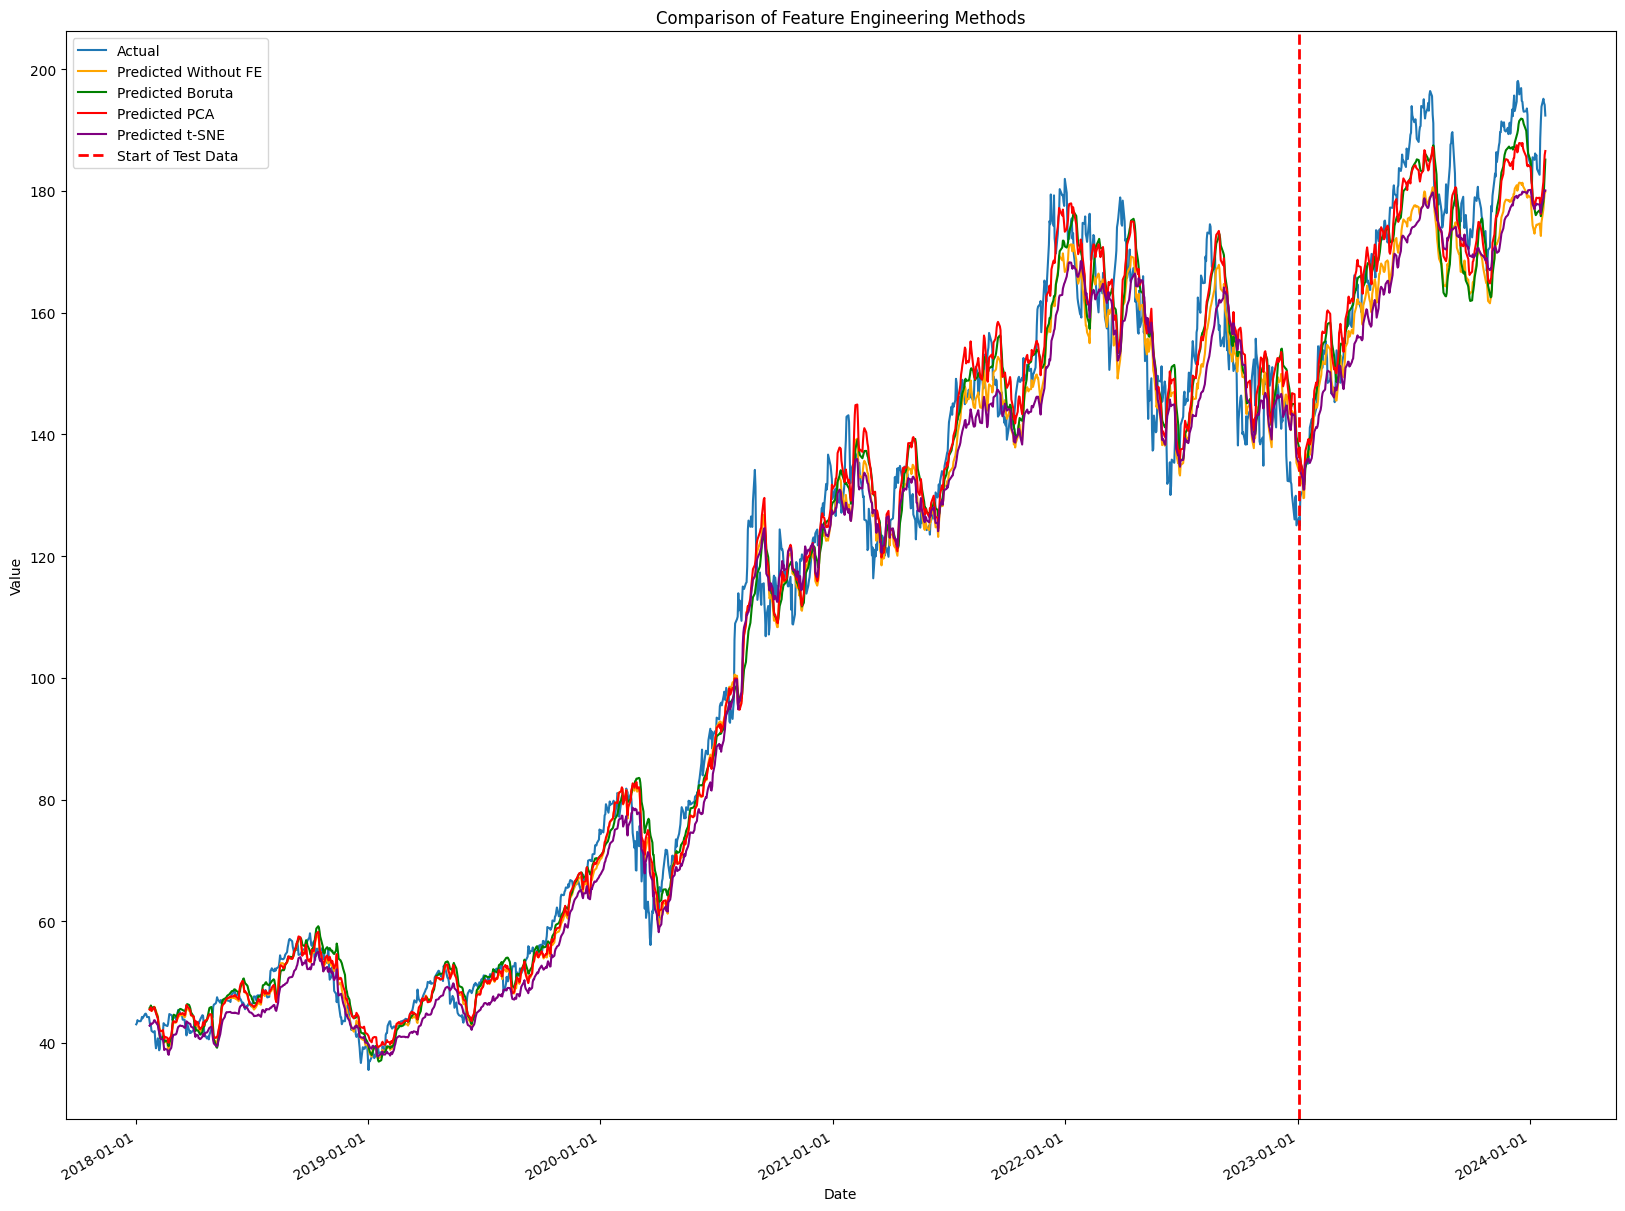

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# Convert 'dates' to a Pandas DatetimeIndex for plotting if it's not already
dates = np.concatenate((Train_date, Test_date), axis=0)
y_actual = np.concatenate((y_train, y_test), axis=0)

# Ensure dates is a datetime object for plotting
dates = pd.to_datetime(dates)
plt.rcParams["figure.figsize"] = (20, 16)
#plt.figure(figsize=(15, 8))  # Adjust the figure size as needed

# Plot the actual values
plt.plot(dates, y_actual, label='Actual')

# Plot predictions from each feature engineering method
colors = ['orange', 'green', 'red', 'purple']  # Different colors for each method
for method, preds in predictions_total.items():
    preds_combined = np.concatenate((preds['train_pred'].flatten(), preds['test_pred'].flatten()))
    if preds_combined.shape[0] < dates.shape[0]:
        # Pad predictions with NaNs for alignment
        pad_length = dates.shape[0] - preds_combined.shape[0]
        preds_combined = np.concatenate((np.full(pad_length, np.nan), preds_combined))

    plt.plot(dates, preds_combined, label=f'Predicted {method}',color=colors.pop(0))

# Mark the start of test data with a vertical line
test_start_date = '2023-01-03'  # Replace with the actual start date of your test set
plt.axvline(x=pd.to_datetime(test_start_date), color='red', linestyle='--', linewidth=2, label='Start of Test Data')

# Finalize the plot
plt.title('Comparison of Feature Engineering Methods')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the x-axis with dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to yearly intervals
plt.gcf().autofmt_xdate()  # Auto-format date labels

plt.show()
